# Outliers Handling - Traffic Accidents

This notebook explores **3 approaches** to handle outliers:
1. **Drop outliers** - Remove records with outlier values
2. **Replace outliers** - Replace outliers with median values
3. **Truncate outliers** - Cap outliers at threshold boundaries

Each approach is evaluated using Naive Bayes and KNN classifiers.

In [ ]:
import sys
import pandas as pd
from pandas import read_csv, DataFrame, Series, concat
from matplotlib.pyplot import figure, savefig, show

sys.path.insert(1, '../../../../utils')
from dslabs_functions import get_variable_types, NR_STDEV, determine_outlier_thresholds_for_var, \
        count_outliers, HEIGHT, plot_multibar_chart, read_train_test_from_files
from studies import evaluate_and_plot, run_all_nb

In [2]:
train_filename = "../../data/prepared/traffic_best_enc_train.csv"
test_filename = "../../data/prepared/traffic_best_enc_test.csv"

In [ ]:
file_tag = "traffic"
metric="f1"
lab_folder_out = "lab3_preparation/outliers"
target_name = "crash_type"

data_train: DataFrame = read_csv(train_filename, na_values="")
data_test: DataFrame = read_csv(test_filename, na_values="")

variable_types: dict[str, list] = get_variable_types(concat([data_train, data_test]))
numeric_vars = variable_types['numeric']

print(f"Train Dataset shape: {data_train.shape}")
print(f"Test Dataset shape: {data_test.shape}")
print(f"Numeric variables: {len(numeric_vars)}")

Train Dataset shape: (146514, 150)
Test Dataset shape: (62792, 150)
Numeric variables: 13


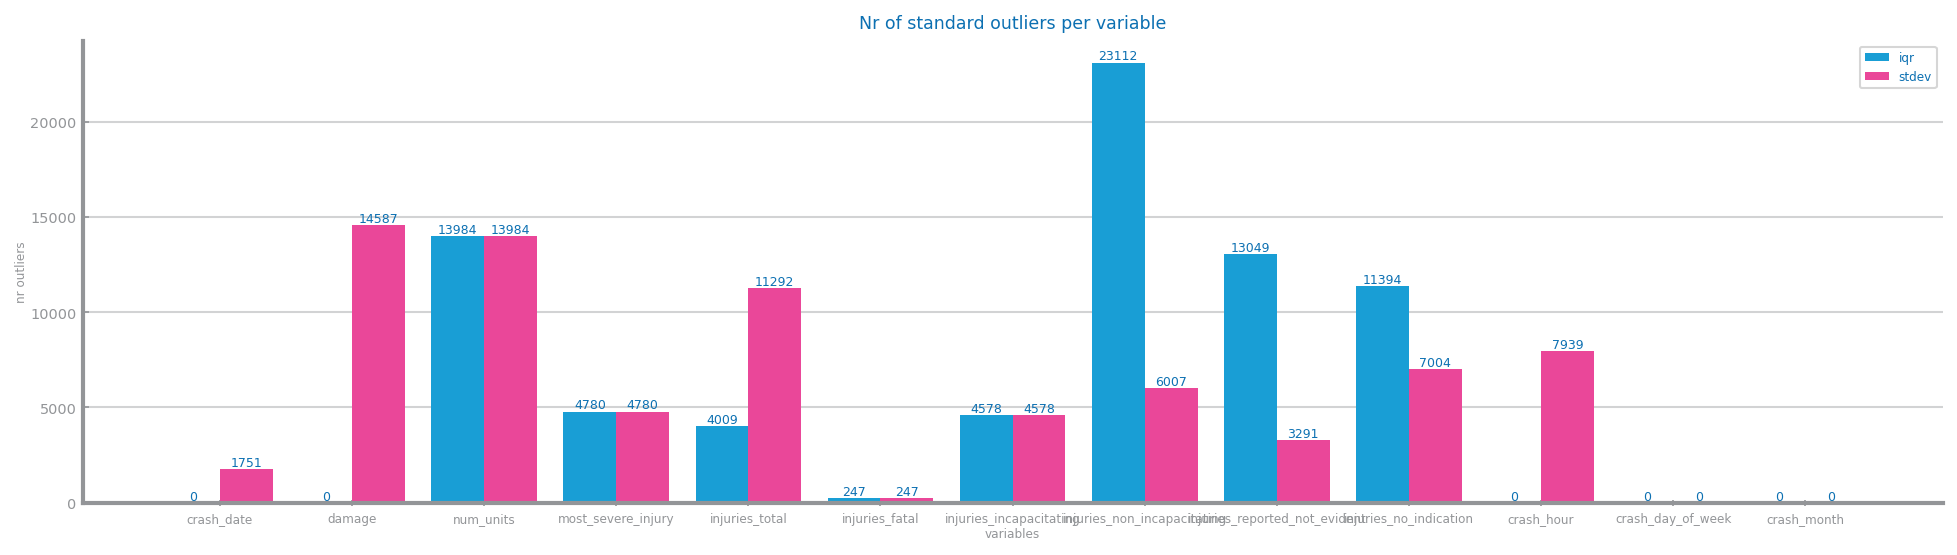

In [4]:
if [] != numeric_vars:
    outliers: dict[str, int] = count_outliers(data_train, numeric_vars)
    figure(figsize=(16, HEIGHT))
    plot_multibar_chart(
        numeric_vars,
        outliers,
        title="Nr of standard outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    show()
else:
    print("There are no numeric variables.")

In [5]:
threshold_std = 5
threshold_iqr = 14.5

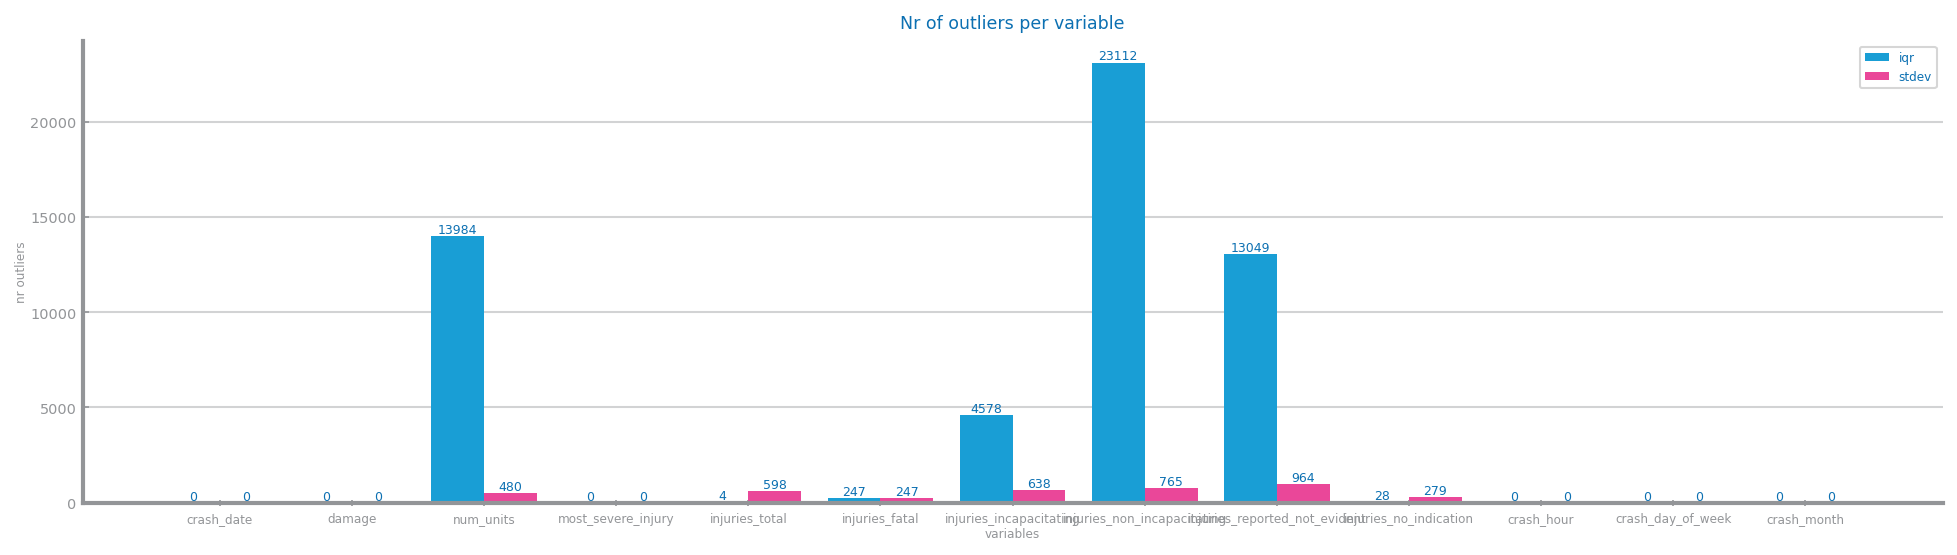

In [6]:
if [] != numeric_vars:
    outliers: dict[str, int] = count_outliers(data_train, numeric_vars, nrstdev=threshold_std, iqrfactor=threshold_iqr)
    figure(figsize=(16, HEIGHT))
    plot_multibar_chart(
        numeric_vars,
        outliers,
        title="Nr of outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    show()
else:
    print("There are no numeric variables.")

In [7]:
std_based = True
threshold = threshold_std

## Approach 1: Drop Outliers

Remove records that contain outlier values (beyond mean ± N*std_dev).

In [8]:
approach_out1 = "drop_outliers"

outliers_vars = numeric_vars

n_std: int = NR_STDEV
if outliers_vars is not None:
    df_out1: DataFrame = data_train.copy(deep=True)
    summary5: DataFrame = data_train[outliers_vars].describe()
    
    for var in outliers_vars:
        top_threshold, bottom_threshold = determine_outlier_thresholds_for_var(summary5[var], std_based, threshold)
        outliers: Series = df_out1[(df_out1[var] > top_threshold) | (df_out1[var] < bottom_threshold)]
        df_out1.drop(outliers.index, axis=0, inplace=True)
    
    print(f"Original data: {data_train.shape}")
    print(f"After dropping outliers: {df_out1.shape}")
    print(f"Records removed: {data_train.shape[0] - df_out1.shape[0]} ({100*(data_train.shape[0] - df_out1.shape[0])/data_train.shape[0]:.1f}%)")
else:
    print("There are no numeric variables")

Original data: (146514, 150)
After dropping outliers: (143269, 150)
Records removed: 3245 (2.2%)


## Approach 2: Replace Outliers with Median

Replace outlier values with the median of the variable.

In [9]:
approach_out2 = "replacing_outliers"

outliers_vars = numeric_vars

if [] != outliers_vars:
    df_out2: DataFrame = data_train.copy(deep=True)
    summary5: DataFrame = data_train[outliers_vars].describe()
    
    for var in outliers_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var], std_based, threshold)
        median: float = df_out2[var].median()
        df_out2[var] = df_out2[var].apply(lambda x: median if x > top or x < bottom else x)
    
    print("Data after replacing outliers:", df_out2.shape)
    print(df_out2.describe())
else:
    print("There are no numeric variables")

Data after replacing outliers: (146514, 150)
         crash_date  intersection_related_i         damage      num_units  \
count  1.465140e+05           146514.000000  146514.000000  146514.000000   
mean   1.607596e+18                0.952360       1.604795       2.052643   
std    7.628944e+16                0.213005       0.661923       0.341842   
min    1.362329e+18                0.000000       0.000000       1.000000   
25%    1.543947e+18                1.000000       1.000000       2.000000   
50%    1.608577e+18                1.000000       2.000000       2.000000   
75%    1.673462e+18                1.000000       2.000000       2.000000   
max    1.737159e+18                1.000000       2.000000       4.000000   

       most_severe_injury  injuries_total  injuries_fatal  \
count        146514.00000   146514.000000        146514.0   
mean              0.47777        0.358532             0.0   
std               0.86997        0.711734             0.0   
min              

## Approach 3: Truncate Outliers

Cap outlier values at the threshold boundaries (windsorizing).

In [10]:
approach_out3 = "truncate_outliers"

outliers_vars = numeric_vars

if [] != outliers_vars:
    df_out3: DataFrame = data_train.copy(deep=True)
    summary5: DataFrame = data_train[outliers_vars].describe()
    
    for var in outliers_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var], std_based, threshold)
        df_out3[var] = df_out3[var].apply(
            lambda x: top if x > top else bottom if x < bottom else x
        )
    
    print("Data after truncating outliers:", df_out3.shape)
    print(df_out3.describe())
else:
    print("There are no numeric variables")

Data after truncating outliers: (146514, 150)
         crash_date  intersection_related_i         damage      num_units  \
count  1.465140e+05           146514.000000  146514.000000  146514.000000   
mean   1.607596e+18                0.952360       1.604795       2.059376   
std    7.628944e+16                0.213005       0.661923       0.360470   
min    1.362329e+18                0.000000       0.000000       1.000000   
25%    1.543947e+18                1.000000       1.000000       2.000000   
50%    1.608577e+18                1.000000       2.000000       2.000000   
75%    1.673462e+18                1.000000       2.000000       2.000000   
max    1.737159e+18                1.000000       2.000000       4.055077   

       most_severe_injury  injuries_total  injuries_fatal  \
count        146514.00000   146514.000000   146514.000000   
mean              0.47777        0.376410        0.000393   
std               0.86997        0.756129        0.009564   
min             

## Evaluate

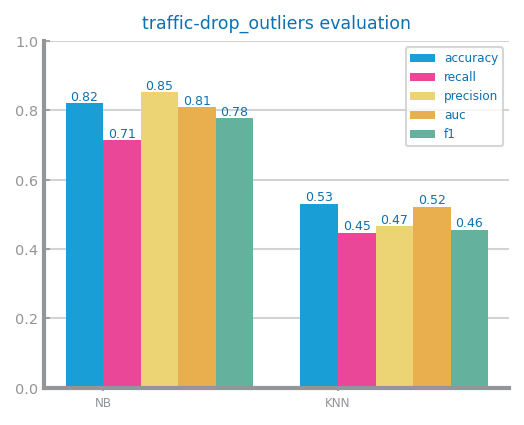

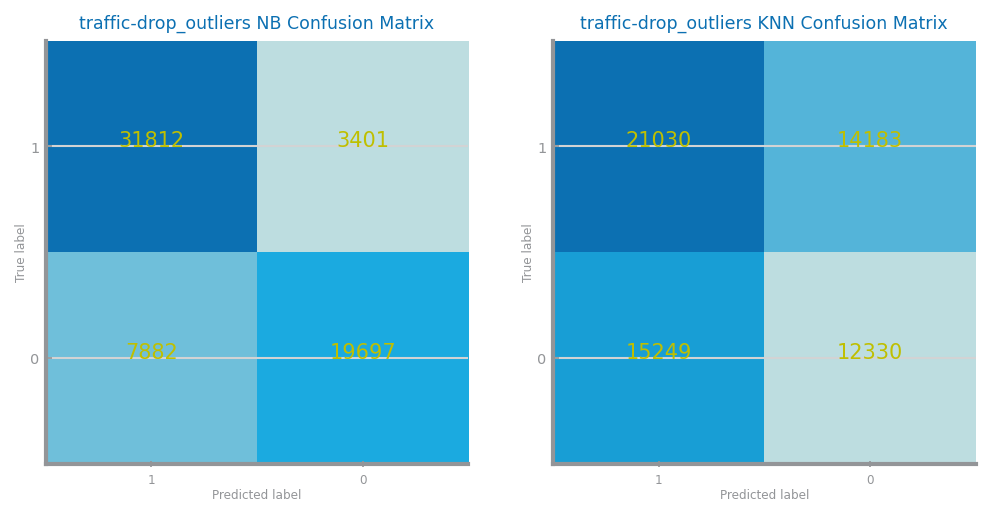

In [11]:
evaluate_and_plot(df_out1, data_test, lab_folder_out, file_tag, approach_out1, target_name, metric=metric)

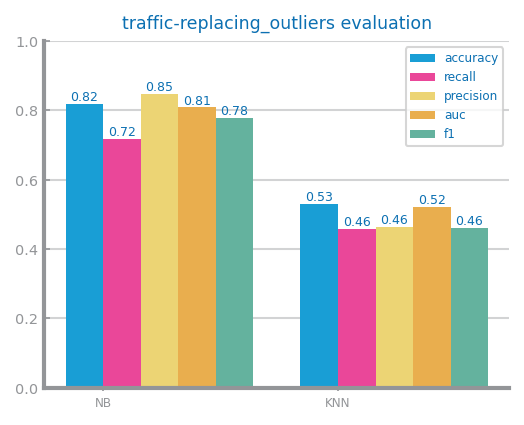

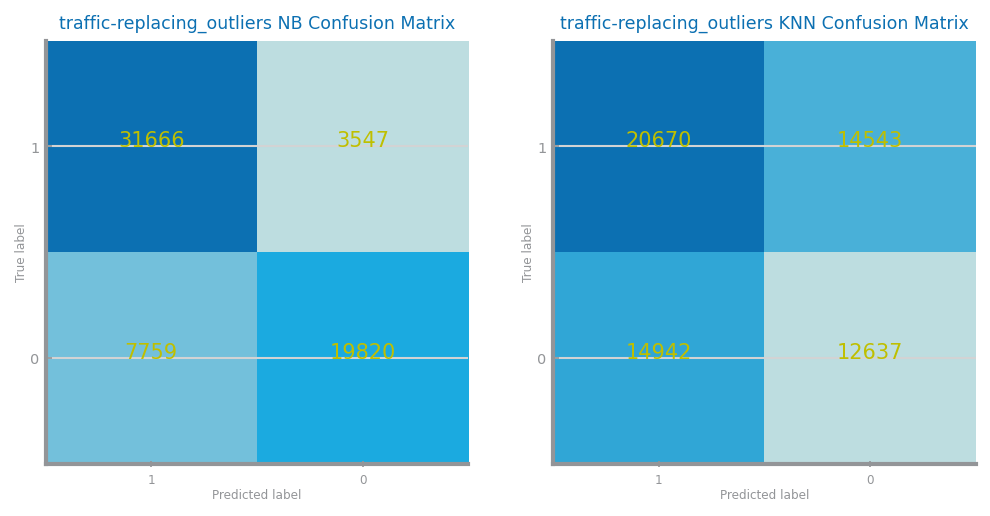

In [12]:
evaluate_and_plot(df_out2, data_test, lab_folder_out, file_tag, approach_out2, target_name, metric=metric)

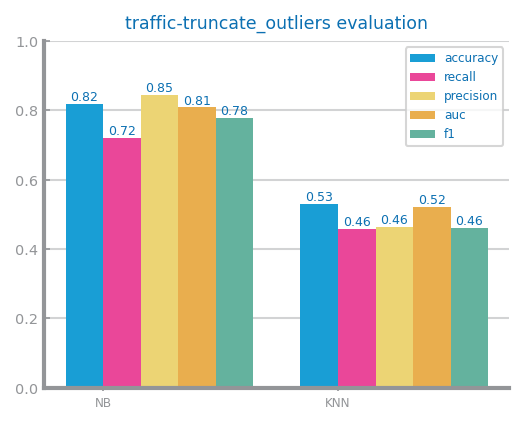

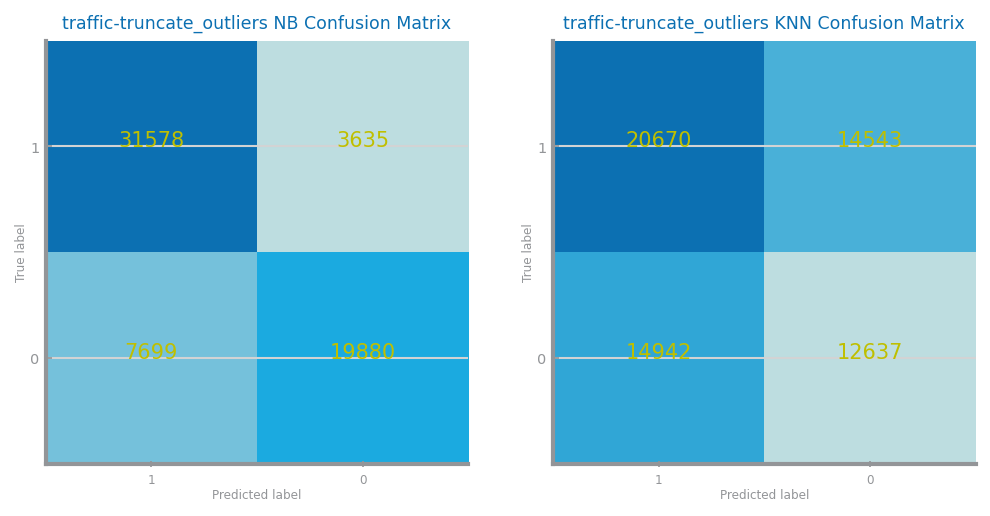

In [13]:
evaluate_and_plot(df_out3, data_test, lab_folder_out, file_tag, approach_out3, target_name, metric=metric)

## Save Best Result

Based on evaluation metrics, save the best performing approach.

In [14]:
# Uncomment to save individual results
df_out1.to_csv(f"../../data/prepared/{file_tag}_outliers_{approach_out1}_train.csv", index=False)
df_out2.to_csv(f"../../data/prepared/{file_tag}_outliers_{approach_out2}_train.csv", index=False)
df_out3.to_csv(f"../../data/prepared/{file_tag}_outliers_{approach_out3}_train.csv", index=False)

# Based on original notebook, approach 3 (truncate) was best
best_df_out_train = df_out3.copy()
best_df_out_test = data_test.copy()
best_approach_out = approach_out3
best_df_out_train.to_csv(f"../../data/prepared/traffic_best_out_train.csv", index=False)
best_df_out_test.to_csv(f"../../data/prepared/traffic_best_out_test.csv", index=False)
print(f"Best approach: {best_approach_out}")
print(f"Shape: {best_df_out_train.shape} {best_df_out_test.shape}")

Best approach: truncate_outliers
Shape: (146514, 150) (62792, 150)


#### **Deeper analysis**

**NAIVE BAYES ANALYSIS - TRAFFIC DATA**

In [15]:
train_filename_1 = f"../../data/prepared/{file_tag}_outliers_{approach_out1}_train.csv"
train_filename_2 = f"../../data/prepared/{file_tag}_outliers_{approach_out2}_train.csv"
train_filename_3 = f"../../data/prepared/{file_tag}_outliers_{approach_out3}_train.csv"
test_filename = f"../../data/prepared/traffic_best_out_test.csv"

In [16]:
# train/test splitting
features_train_out1, features_test_out1, target_train_out1, target_test_out1, labels, vars = read_train_test_from_files(train_filename_1, test_filename, target_name)
features_train_out2, features_test_out2, target_train_out2, target_test_out2, labels, vars = read_train_test_from_files(train_filename_2, test_filename, target_name)
features_train_out3, features_test_out3, target_train_out3, target_test_out3, labels, vars = read_train_test_from_files(train_filename_3, test_filename, target_name)

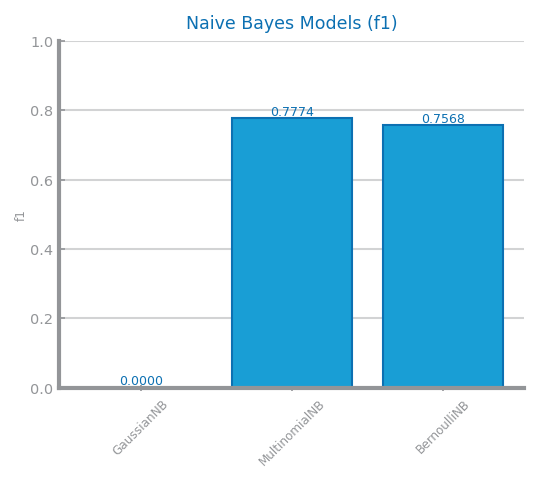

<Figure size 600x450 with 0 Axes>

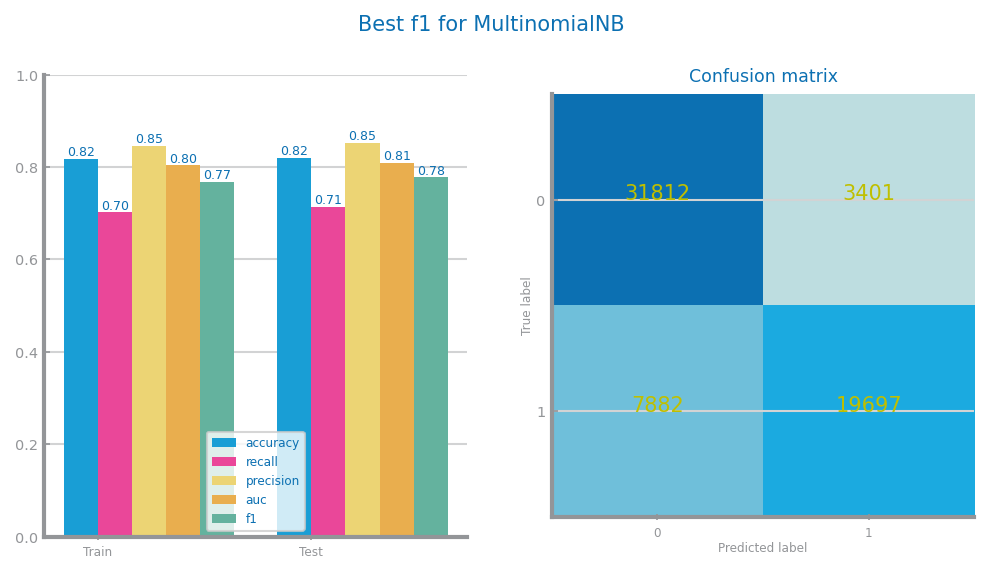

In [17]:
metrics = [#"accuracy", "recall", 
    "f1"] 
for el in metrics:
    nb_best_model, nb_params = run_all_nb(
        features_train_out1, target_train_out1, features_test_out1, target_test_out1, 
        lab_folder_out, file_tag, approach_out1,
        eval_metric = el
    )

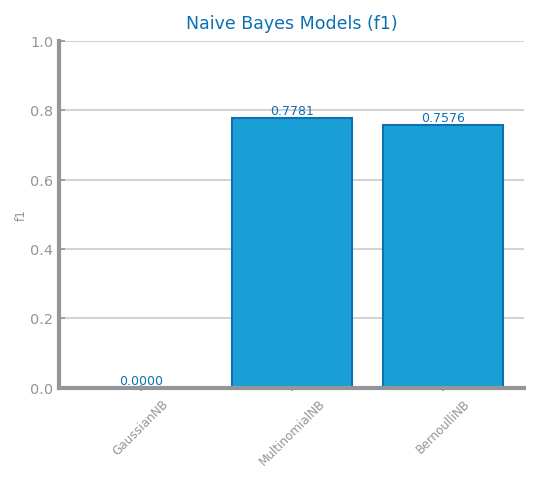

<Figure size 600x450 with 0 Axes>

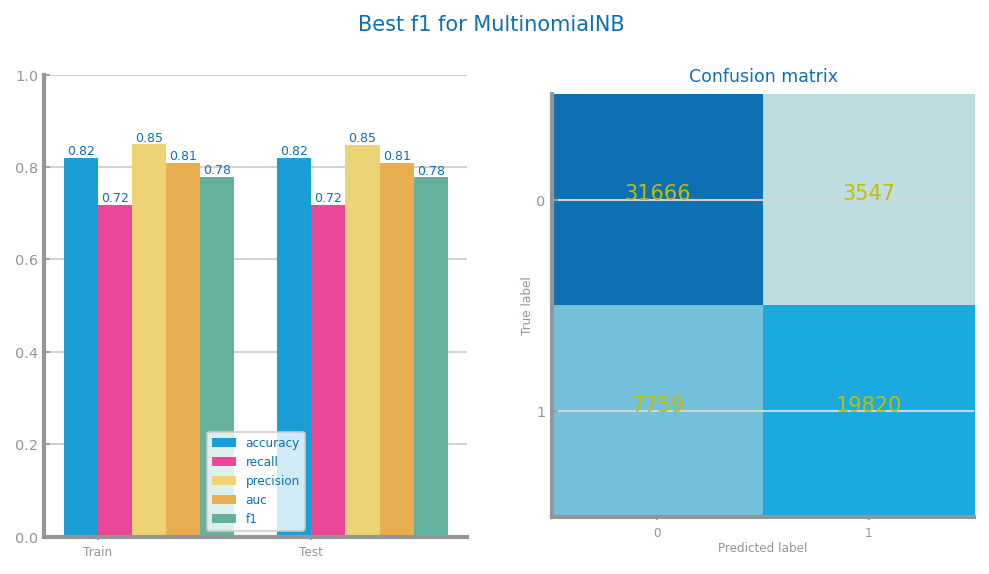

In [18]:
metrics = [#"accuracy", "recall", 
    "f1"] 
for el in metrics:
    nb_best_model, nb_params = run_all_nb(
        features_train_out2, target_train_out2, features_test_out2, target_test_out2, 
        lab_folder_out, file_tag, approach_out2,
        eval_metric = el
    )

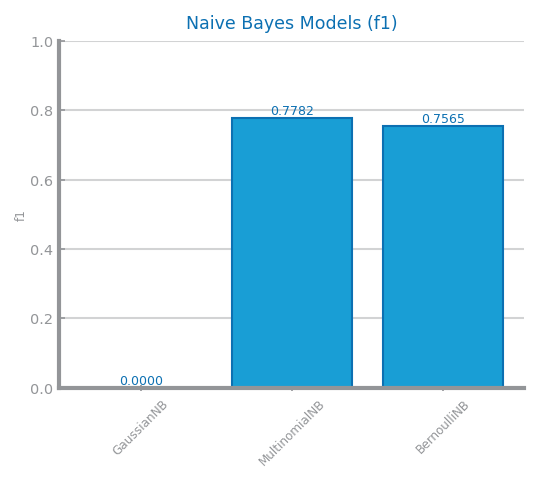

<Figure size 600x450 with 0 Axes>

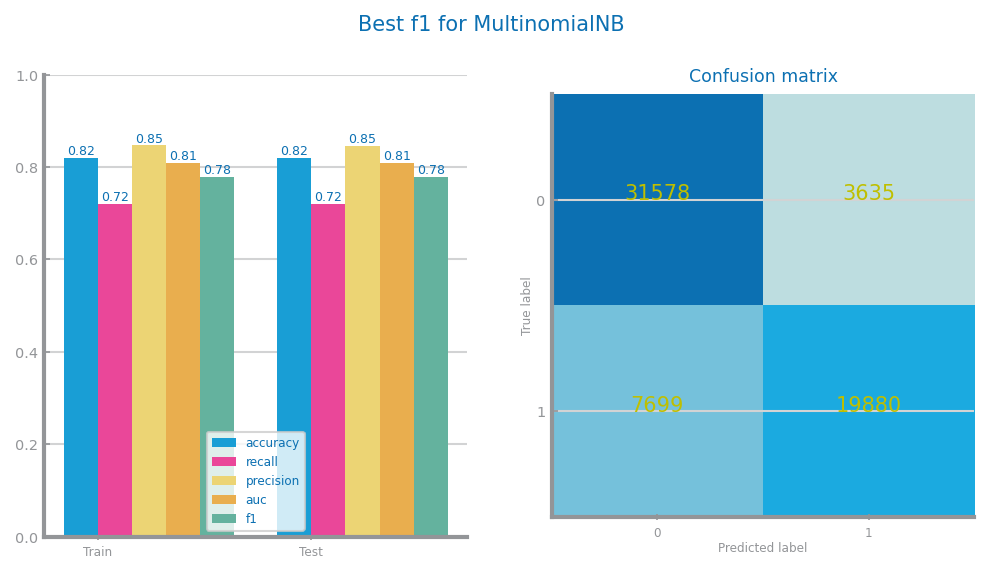

In [19]:
metrics = [#"accuracy", "recall", 
    "f1"] 
for el in metrics:
    nb_best_model, nb_params = run_all_nb(
        features_train_out3, target_train_out3, features_test_out3, target_test_out3, 
        lab_folder_out, file_tag, approach_out3,
        eval_metric = el
    )